In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.stats import zscore
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report

In [3]:
df = pd.read_csv('spotify-2023.csv', encoding='latin1')

#df.info()
df['streams'] = pd.to_numeric(df['streams'], errors='coerce')
df['in_deezer_playlists'] = pd.to_numeric(df['in_deezer_playlists'], errors='coerce')
df['in_shazam_charts'] = pd.to_numeric(df['in_shazam_charts'], errors='coerce')
df['streams'] = df['streams'].astype('float64').round(0)

In [4]:
df

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703.0,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286.0,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974.0,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817.0,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322.0,84,...,144,A,Minor,65,23,80,14,63,11,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,My Mind & Me,Selena Gomez,1,2022,11,3,953,0,91473363.0,61,...,144,A,Major,60,24,39,57,0,8,3
949,Bigger Than The Whole Sky,Taylor Swift,1,2022,10,21,1180,0,121871870.0,4,...,166,F#,Major,42,7,24,83,1,12,6
950,A Veces (feat. Feid),"Feid, Paulo Londra",2,2022,11,3,573,0,73513683.0,2,...,92,C#,Major,80,81,67,4,0,8,6
951,En La De Ella,"Feid, Sech, Jhayco",3,2022,10,20,1320,0,133895612.0,29,...,97,C#,Major,82,67,77,8,0,12,5


# 0 - Pré analise

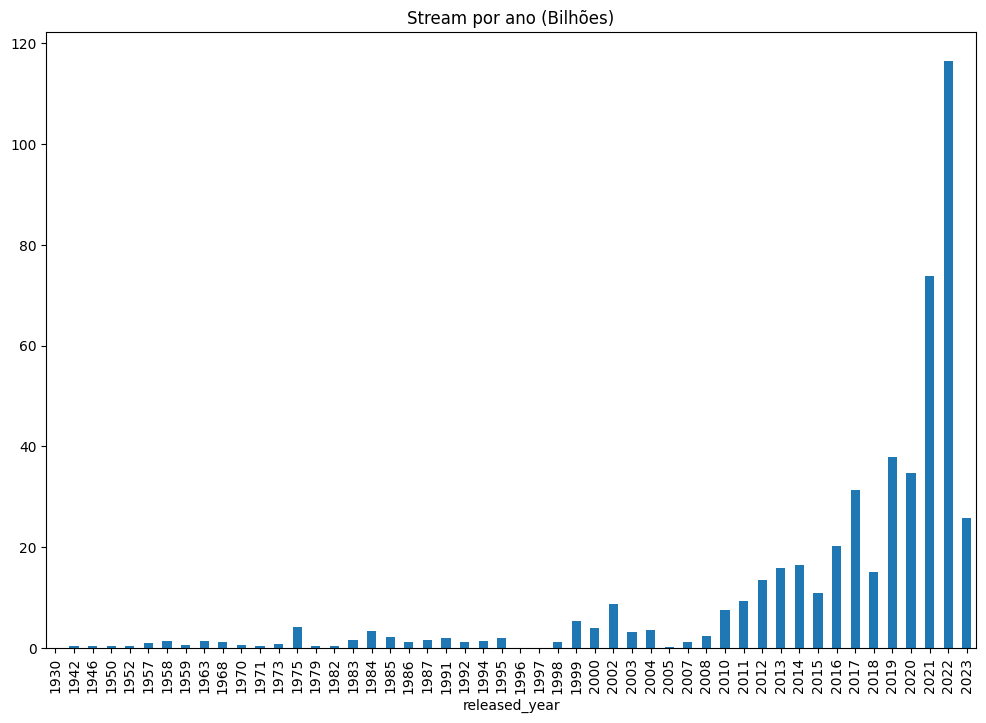

In [5]:
streams_by_year = df.groupby('released_year')['streams'].sum()
streams_by_year = streams_by_year/1000000000
plt.figure(figsize=(12, 8))
streams_by_year.plot(kind='bar')
plt.title('Stream por ano (Bilhões)')
plt.show()

,released_year,artist(s)_name,streams,streams_pct
29,2000,Linkin Park,1.624166e+09,4.128562e+08
30,2002,Eminem,3.517657e+09,4.052730e+08
31,2003,The Killers,1.806618e+09,5.702630e+08
32,2004,Eminem,1.241559e+09,3.531452e+08
33,2005,"Gwen Stefani, Blake Shelton",1.805775e+08,1.000000e+09
34,2007,Arctic Monkeys,1.217121e+09,1.000000e+09
35,2008,Coldplay,1.592910e+09,6.420911e+08
36,2010,Bruno Mars,2.704383e+09,3.572577e+08
37,2011,"Ray Dalton, Ryan Lewis, Macklemore",1.953534e+09,2.086393e+08
38,2012,Bruno Mars,3.142537e+09,2.342495e+08


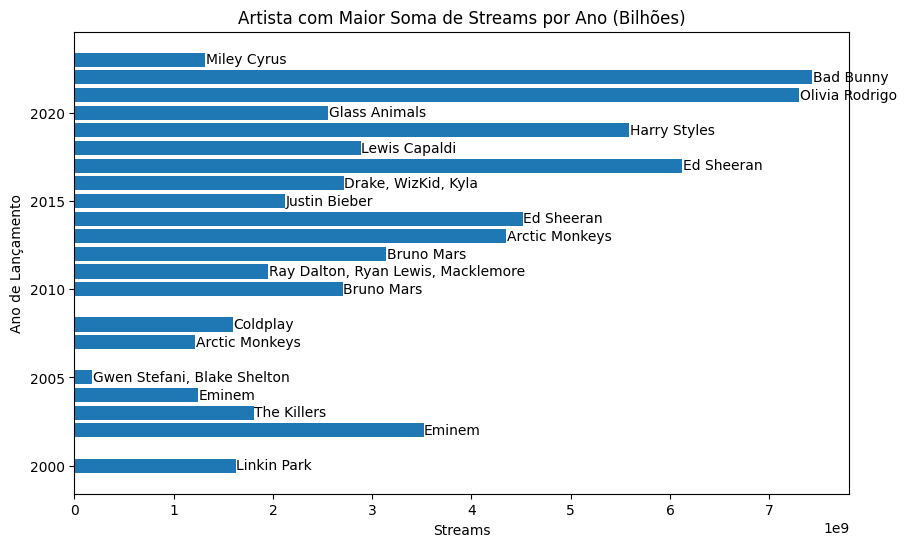

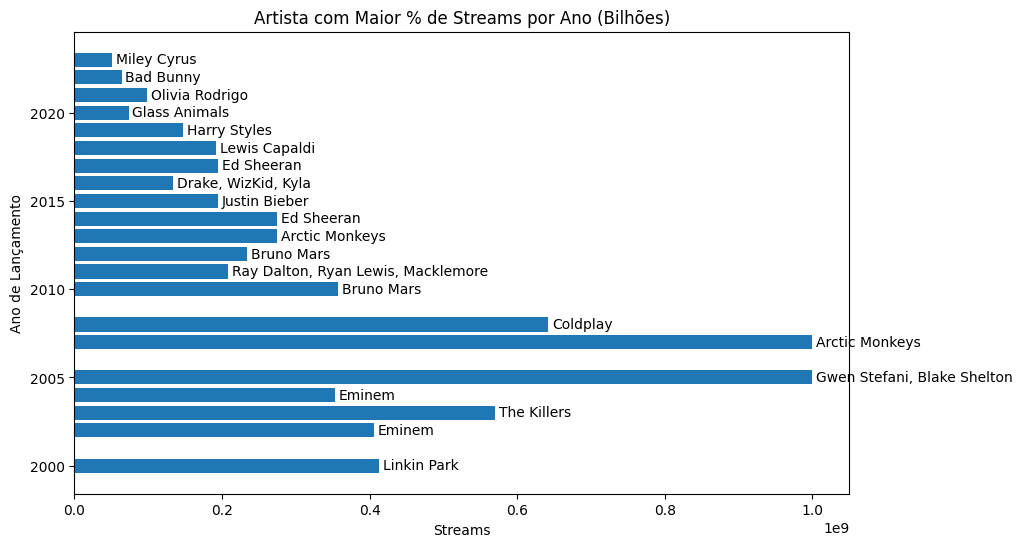

In [6]:
# top_artist_per_year = df.loc[df.groupby('released_year')['streams'].idxmax()][['released_year', 'artist(s)_name', 'streams']]

top_artist_per_year = df.groupby(['released_year', 'artist(s)_name'], as_index=False)['streams'].sum()
top_artist_per_year = top_artist_per_year.loc[top_artist_per_year.groupby('released_year')['streams'].idxmax()].reset_index(drop=True)

top_artist_per_year = top_artist_per_year[top_artist_per_year['released_year'] >= 2000]

top_artist_per_year['streams_pct'] = top_artist_per_year['streams'] / streams_by_year.loc[top_artist_per_year['released_year']].values

display(top_artist_per_year)

plt.figure(figsize=(10, 6))
bars = plt.barh(top_artist_per_year['released_year'], top_artist_per_year['streams'])

for bar, artist in zip(bars, top_artist_per_year['artist(s)_name']):
    plt.text(bar.get_width() + 5e6, bar.get_y() + bar.get_height() / 2, artist, va='center')

plt.xlabel('Streams')
plt.ylabel('Ano de Lançamento')
plt.title('Artista com Maior Soma de Streams por Ano (Bilhões)')

plt.show()


plt.figure(figsize=(10, 6))
bars = plt.barh(top_artist_per_year['released_year'], top_artist_per_year['streams_pct'])

for bar, artist in zip(bars, top_artist_per_year['artist(s)_name']):
    plt.text(bar.get_width() + 5e6, bar.get_y() + bar.get_height() / 2, artist, va='center')

plt.xlabel('Streams')
plt.ylabel('Ano de Lançamento')
plt.title('Artista com Maior % de Streams por Ano (Bilhões)')

plt.show()

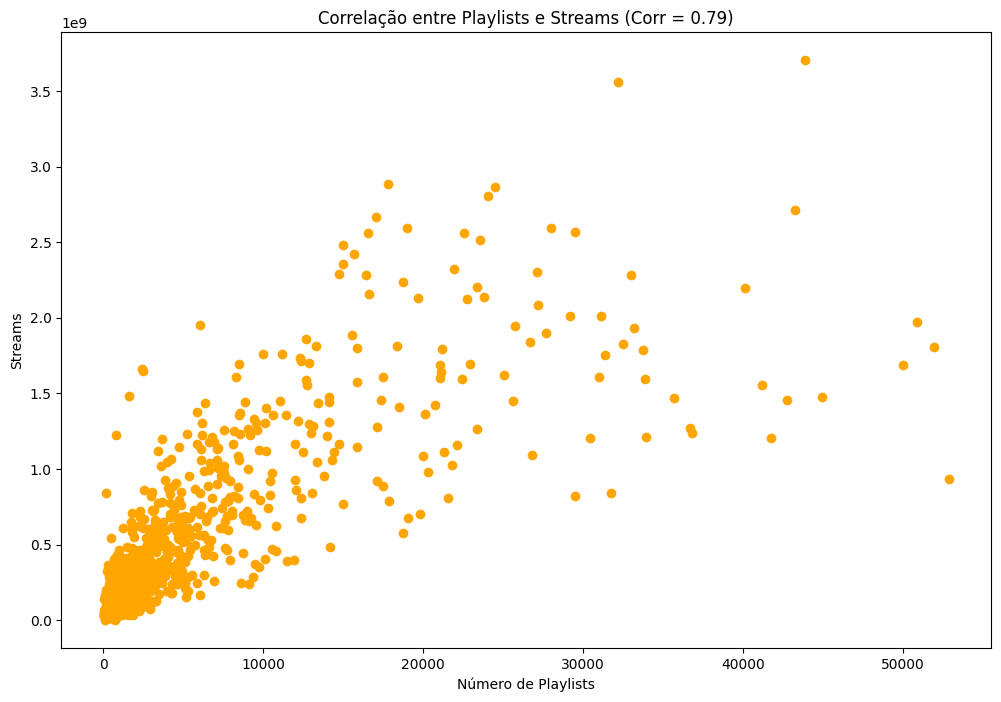

In [7]:
playlist_stream_correlation = df[['in_spotify_playlists', 'streams']].corr().iloc[0, 1]

plt.figure(figsize=(12, 8))
plt.scatter(df['in_spotify_playlists'], df['streams'], color='orange')
plt.title(f'Correlação entre Playlists e Streams (Corr = {playlist_stream_correlation:.2f})')
plt.xlabel('Número de Playlists')
plt.ylabel('Streams')
plt.show()

## 1 - Limpeza/Tratamento dos dados

- #### Definindo tipos, transformando str em números e excluindo colunas que não nos interessam

In [8]:
df = df[['artist_count', 'released_month', 'released_day', 'streams', 'bpm',
       'key', 'mode', 'danceability_%', 'valence_%', 'energy_%',
       'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']]

df = df.dropna().reset_index(drop=True)

df['mode'] = df['mode'].map({'Major': 1, 'Minor': 0})

df['key'], key_mapping = pd.factorize(df['key'])
key_mapping = dict(enumerate(key_mapping))
#print(key_mapping)

df

,artist_count,released_month,released_day,streams,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,2,7,14,141381703.0,125,0,1,80,89,83,31,0,8,4
1,1,3,23,133716286.0,92,1,1,71,61,74,7,0,10,4
2,1,6,30,140003974.0,138,2,1,51,32,53,17,0,31,6
3,1,8,23,800840817.0,170,3,1,55,58,72,11,0,11,15
4,1,5,18,303236322.0,144,3,0,65,23,80,14,63,11,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,1,11,3,91473363.0,144,3,1,60,24,39,57,0,8,3
853,1,10,21,121871870.0,166,5,1,42,7,24,83,1,12,6
854,2,11,3,73513683.0,92,1,1,80,81,67,4,0,8,6
855,3,10,20,133895612.0,97,1,1,82,67,77,8,0,12,5


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
artist_count,857.0,1.551925e+00,8.646344e-01,1.0,1.0,1.0,2.0,8.000000e+00
released_month,857.0,6.031505e+00,3.567138e+00,1.0,3.0,5.0,9.0,1.200000e+01
released_day,857.0,1.373979e+01,9.287652e+00,1.0,5.0,13.0,22.0,3.100000e+01
streams,857.0,5.133554e+08,5.714855e+08,2762.0,139193812.0,284908316.0,674072710.0,3.703895e+09
bpm,857.0,1.228425e+02,2.819657e+01,65.0,100.0,121.0,142.0,2.060000e+02
key,857.0,4.394399e+00,2.975502e+00,0.0,2.0,4.0,7.0,1.000000e+01
mode,857.0,5.530922e-01,4.974635e-01,0.0,0.0,1.0,1.0,1.000000e+00
danceability_%,857.0,6.727305e+01,1.465316e+01,23.0,57.0,70.0,78.0,9.600000e+01
valence_%,857.0,5.121937e+01,2.359458e+01,4.0,32.0,51.0,70.0,9.700000e+01
energy_%,857.0,6.433956e+01,1.605635e+01,14.0,53.0,66.0,76.0,9.700000e+01


- #### Excluindo outliers com zscore

In [10]:
threshold = 3

z_scores = zscore(df)
abs_z_scores = abs(z_scores)
filtered_entries = (abs_z_scores < threshold).all(axis=1)

df_filtered_no_outliers_zscore = df[filtered_entries]

df_filtered = df_filtered_no_outliers_zscore.reset_index(drop=True)

In [11]:
df_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
artist_count,778.0,1.502571e+00,7.268476e-01,1.0,1.000000e+00,1.0,2.000000e+00,4.000000e+00
released_month,778.0,6.016710e+00,3.581876e+00,1.0,3.000000e+00,5.0,9.000000e+00,1.200000e+01
released_day,778.0,1.373136e+01,9.331094e+00,1.0,5.000000e+00,13.0,2.200000e+01,3.100000e+01
streams,778.0,4.699079e+08,4.691139e+08,2762.0,1.374265e+08,284864095.0,6.524617e+08,2.204081e+09
bpm,778.0,1.230167e+02,2.808666e+01,65.0,1.000000e+02,121.0,1.417500e+02,2.060000e+02
key,778.0,4.419023e+00,2.979423e+00,0.0,2.000000e+00,4.0,7.000000e+00,1.000000e+01
mode,778.0,5.552699e-01,4.972555e-01,0.0,0.000000e+00,1.0,1.000000e+00,1.000000e+00
danceability_%,778.0,6.762339e+01,1.438032e+01,24.0,5.800000e+01,70.0,7.900000e+01,9.600000e+01
valence_%,778.0,5.164139e+01,2.370157e+01,4.0,3.300000e+01,51.0,7.100000e+01,9.700000e+01
energy_%,778.0,6.456298e+01,1.569798e+01,23.0,5.400000e+01,66.0,7.600000e+01,9.700000e+01


In [12]:
df_filtered

,artist_count,released_month,released_day,streams,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,2,7,14,141381703.0,125,0,1,80,89,83,31,0,8,4
1,1,3,23,133716286.0,92,1,1,71,61,74,7,0,10,4
2,1,6,30,140003974.0,138,2,1,51,32,53,17,0,31,6
3,1,8,23,800840817.0,170,3,1,55,58,72,11,0,11,15
4,2,6,1,183706234.0,141,1,1,92,66,58,19,0,8,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,1,11,3,91473363.0,144,3,1,60,24,39,57,0,8,3
774,1,10,21,121871870.0,166,5,1,42,7,24,83,1,12,6
775,2,11,3,73513683.0,92,1,1,80,81,67,4,0,8,6
776,3,10,20,133895612.0,97,1,1,82,67,77,8,0,12,5


 ##### Antes e Depois


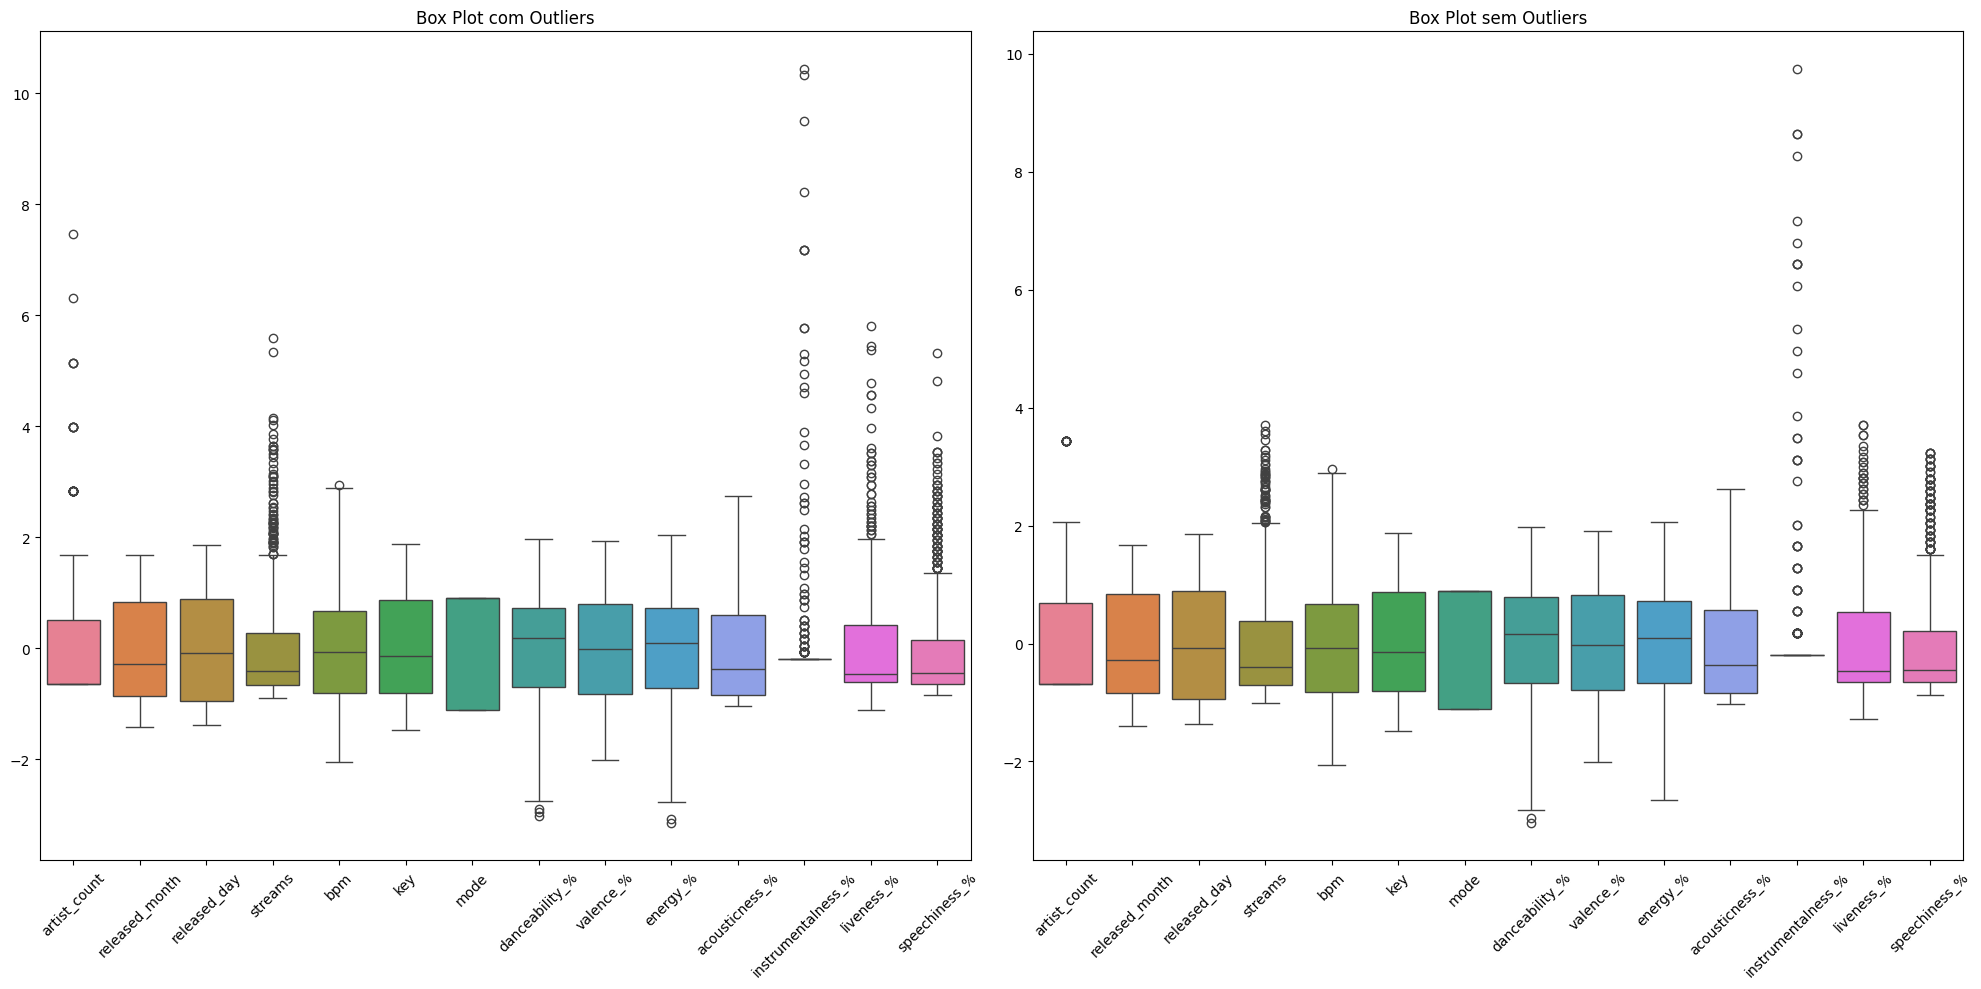

In [13]:
df_normalizado_antes = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns)
df_normalizado = pd.DataFrame(StandardScaler().fit_transform(df_filtered), columns=df_filtered.columns)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_normalizado_antes)
plt.xticks(rotation=45)
plt.title('Box Plot com Outliers')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_normalizado)
plt.xticks(rotation=45)
plt.title('Box Plot sem Outliers')

plt.tight_layout()
plt.show()

## 2 - Analises

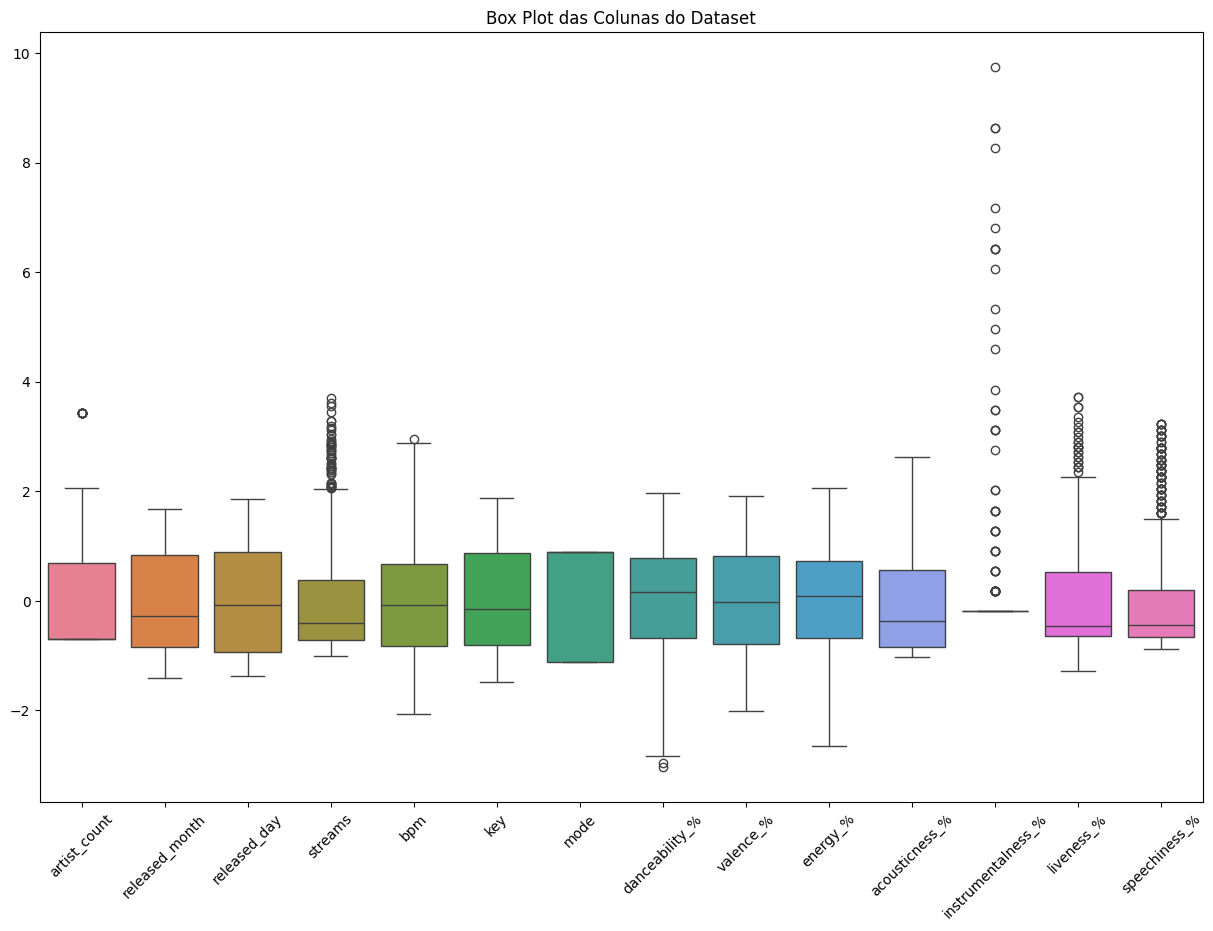

In [14]:
# Plotando o box plot das colunas do dataset
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_normalizado)
plt.xticks(rotation=45)
plt.title('Box Plot das Colunas do Dataset')
plt.show()

- #### Matriz de correlacao

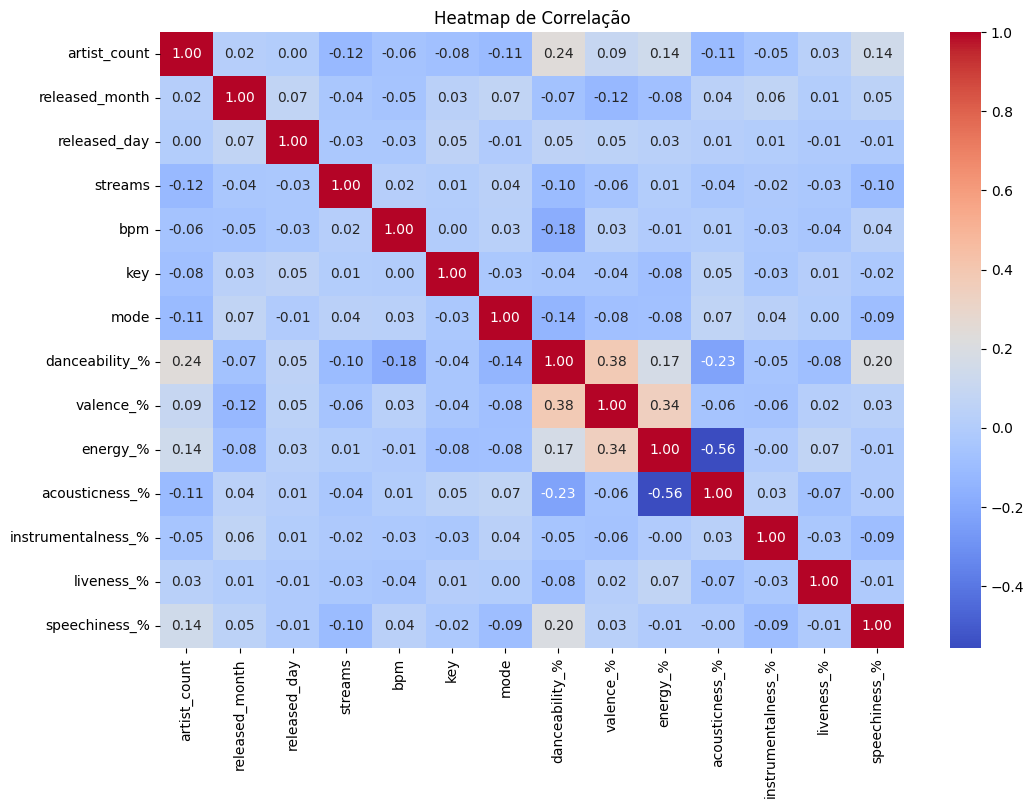

In [15]:
correlacao = df_filtered.corr(method='pearson')
plt.figure(figsize=(12, 8))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap de Correlação')
plt.show()

In [16]:
# Identificar colunas com correlação absoluta maior que 0.20
colunas_com_corr = correlacao.columns[(correlacao[correlacao != 1.00].abs() > 0.20).any()].tolist()
colunas_com_corr.append('streams')

- #### Pairplot das variaveis mais interessante (com maior correlacao)

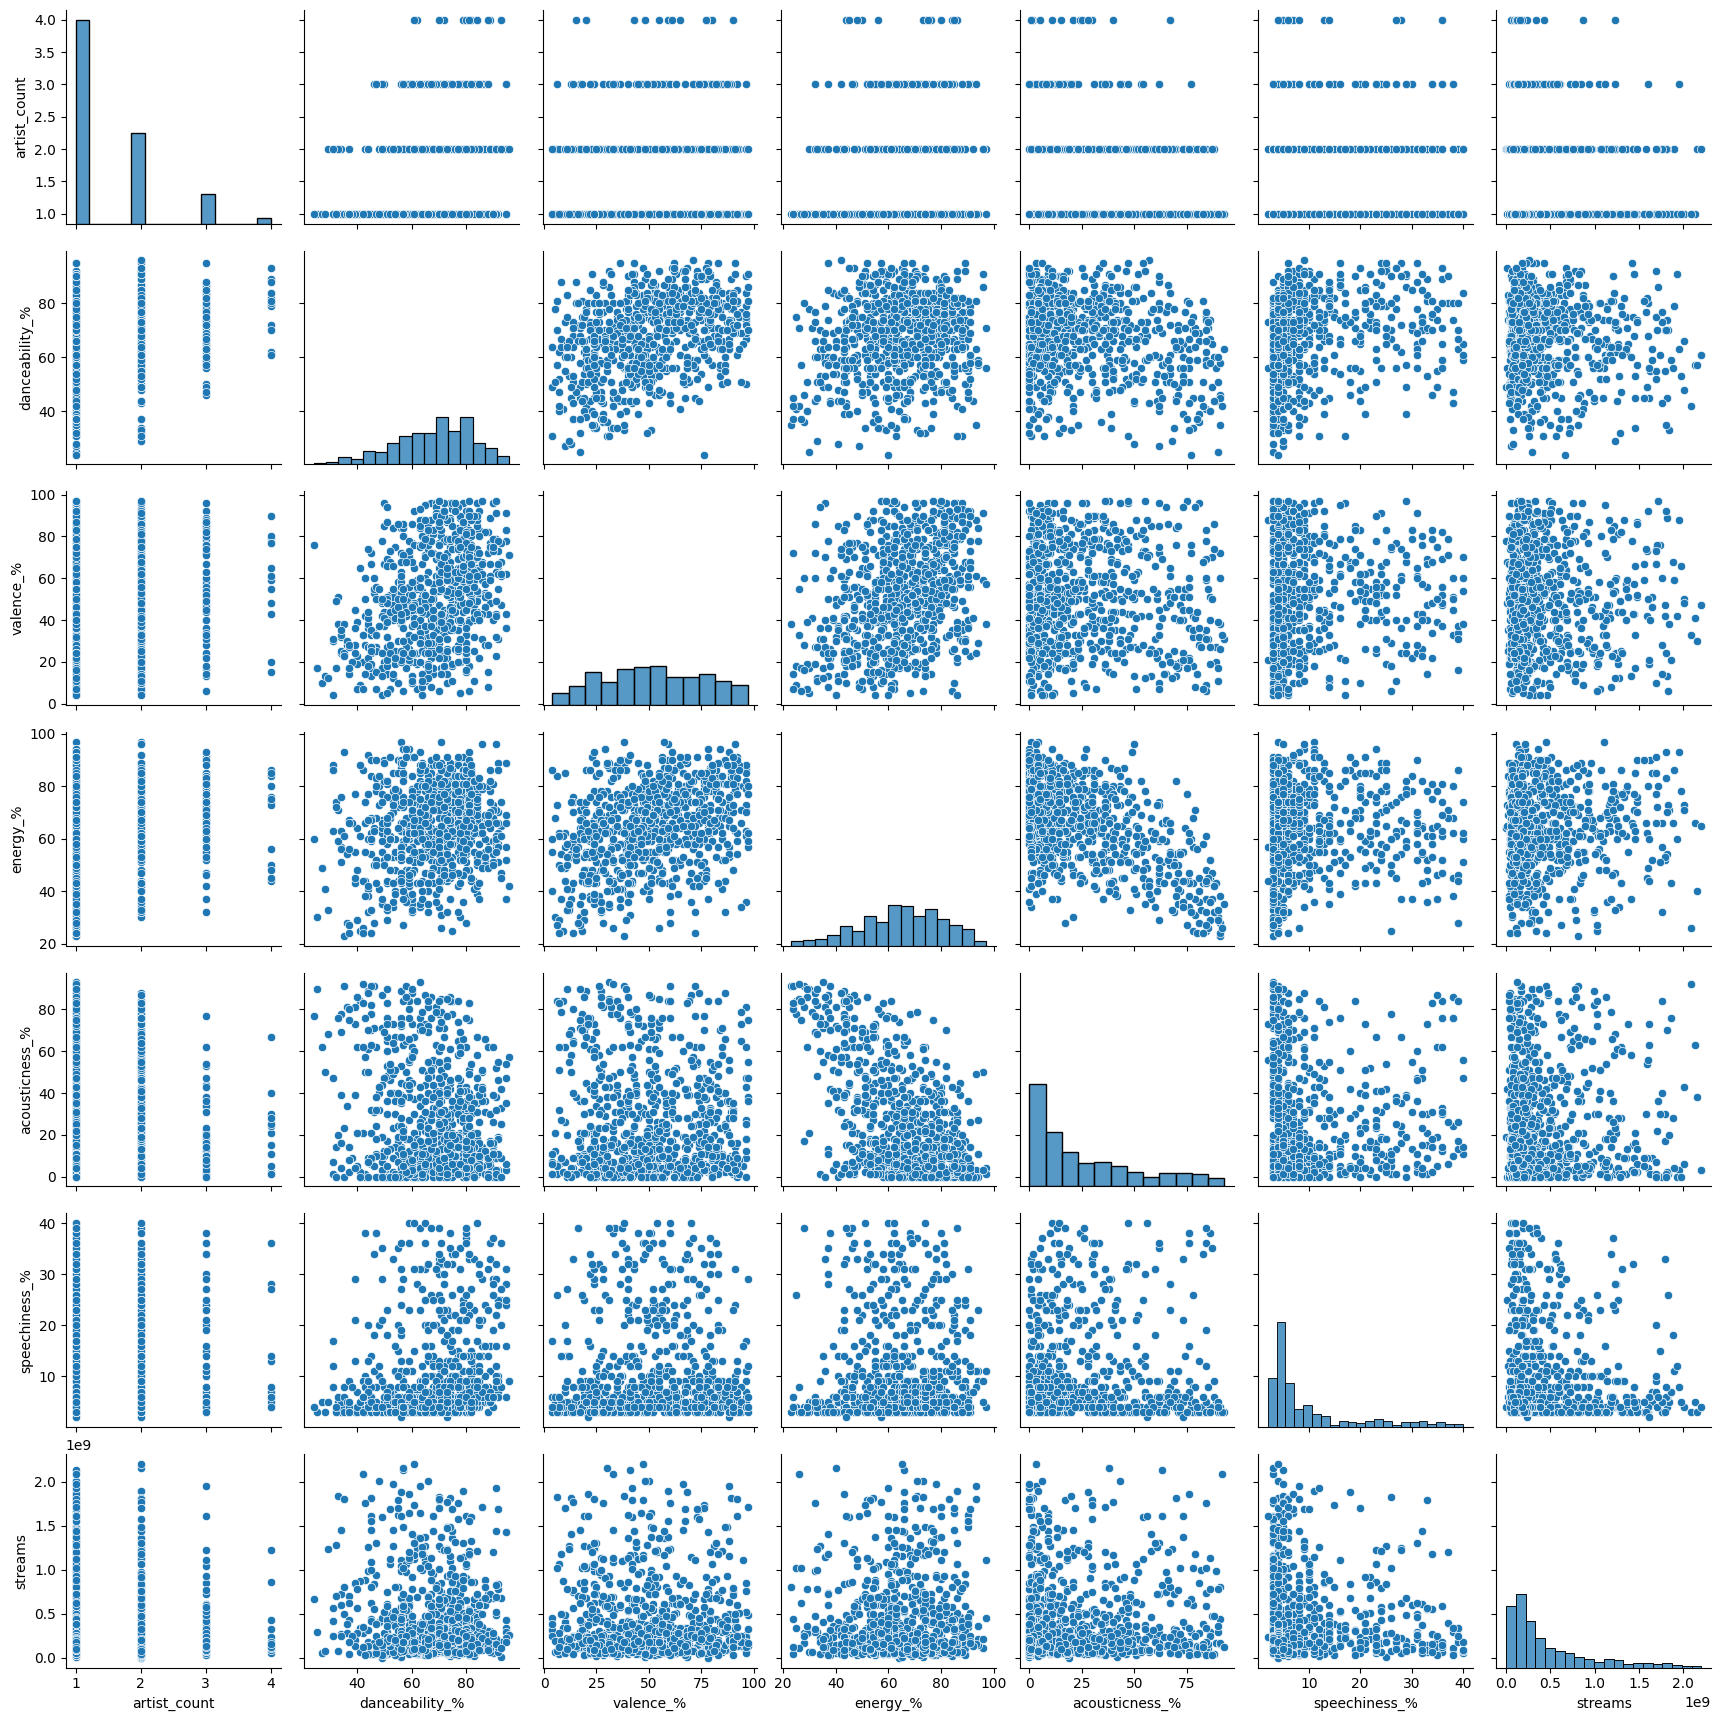

In [17]:
sns.pairplot(df_filtered[colunas_com_corr])
plt.show()

# 3 - Modelo de Classificação

In [18]:
# Agrupa a quantidade de streams em 3 magnitudes
df_filtered['streams_category'] = pd.qcut(df_filtered['streams'], q=3, labels=['Low', 'Medium', 'High'])

X = df_filtered.drop(columns=['streams', 'streams_category'])  
y = df_filtered['streams_category']  


scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

- ##### Usando RFE Para Avaliar Métricas

In [19]:
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=8)  
X_rfe = rfe.fit_transform(X_scaled, y)

print("Logistic Regression RFE features:", X.columns[rfe.support_].tolist())

selected_features = X.columns[rfe.support_]

Logistic Regression RFE features: ['artist_count', 'released_month', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'liveness_%', 'speechiness_%']


- ##### Realizando Avaliações

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.3)

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'K-Neighbors': KNeighborsClassifier(),
    'SVM': SVC()
}

results = {}
for name, model in models.items():
    # cross-validation com 5 folds
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    results[name] = {
        'Cross-Validation Mean Accuracy': cv_scores.mean(),
        'Test Accuracy': accuracy,
        'Classification Report': report,
        'Standard Deviation': cv_scores.std()
    }

for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Cross-Validation Mean Accuracy: {result['Cross-Validation Mean Accuracy']}")
    print(f"Standard Deviation: {result['Standard Deviation']}")
    print(f"Test Accuracy: {result['Test Accuracy']}")
    print(f"Classification Report:\n{result['Classification Report']}")
    print("\n" + "="*60 + "\n")

Model: Logistic Regression
Cross-Validation Mean Accuracy: 0.3823139653414883
Standard Deviation: 0.04212728621190917
Test Accuracy: 0.36752136752136755
Classification Report:
              precision    recall  f1-score   support

        High       0.36      0.31      0.34        80
         Low       0.34      0.45      0.39        73
      Medium       0.42      0.35      0.38        81

    accuracy                           0.37       234
   macro avg       0.37      0.37      0.37       234
weighted avg       0.37      0.37      0.37       234



Model: Random Forest
Cross-Validation Mean Accuracy: 0.45208970438328244
Standard Deviation: 0.04088923775765867
Test Accuracy: 0.4444444444444444
Classification Report:
              precision    recall  f1-score   support

        High       0.44      0.35      0.39        80
         Low       0.41      0.55      0.47        73
      Medium       0.49      0.44      0.46        81

    accuracy                           0.44       234

# 4 - Modelos usando rede neural

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [22]:
# Definindo os modelos
models = {
    'Neural Network 1': MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000),  
    'Neural Network 2': MLPClassifier(hidden_layer_sizes=(50, 50, 50, 50, 50), max_iter=1000),
    'Decision Tree': DecisionTreeClassifier()
}

results = {}

# Treinando e avaliando os modelos
for name, model in models.items():
    # cross-validation com 5 folds
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    results[name] = {
        'Cross-Validation Mean Accuracy': cv_scores.mean(),
        'Test Accuracy': accuracy,
        'Classification Report': report,
        'Standard Deviation': cv_scores.std()
    }

# Exibindo os resultados
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Cross-Validation Mean Accuracy: {result['Cross-Validation Mean Accuracy']}")
    print(f"Standard Deviation: {result['Standard Deviation']}")
    print(f"Test Accuracy: {result['Test Accuracy']}")
    print(f"Classification Report:\n{result['Classification Report']}")
    print("\n" + "="*60 + "\n")


Model: Neural Network 1
Cross-Validation Mean Accuracy: 0.39889568467550124
Standard Deviation: 0.03358557567903404
Test Accuracy: 0.36752136752136755
Classification Report:
              precision    recall  f1-score   support

        High       0.41      0.31      0.35        80
         Low       0.32      0.44      0.37        73
      Medium       0.40      0.36      0.38        81

    accuracy                           0.37       234
   macro avg       0.38      0.37      0.37       234
weighted avg       0.38      0.37      0.37       234



Model: Neural Network 2
Cross-Validation Mean Accuracy: 0.3877336051647978
Standard Deviation: 0.04744393627380719
Test Accuracy: 0.39316239316239315
Classification Report:
              precision    recall  f1-score   support

        High       0.39      0.36      0.38        80
         Low       0.37      0.44      0.40        73
      Medium       0.42      0.38      0.40        81

    accuracy                           0.39       23

In [23]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix
import seaborn as sns

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3084 - loss: 1.1270 - val_accuracy: 0.3578 - val_loss: 1.0870
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4390 - loss: 1.0647 - val_accuracy: 0.3394 - val_loss: 1.0998
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4849 - loss: 1.0474 - val_accuracy: 0.3761 - val_loss: 1.1062
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4973 - loss: 1.0316 - val_accuracy: 0.3486 - val_loss: 1.1081
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4933 - loss: 1.0321 - val_accuracy: 0.3486 - val_loss: 1.1153
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5164 - loss: 1.0098 - val_accuracy: 0.3486 - val_loss: 1.1207
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4778 - loss: 1.0051 - val_accuracy: 0.3486 - val_loss: 1.1228
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5307 - loss: 0.9680 - val_accuracy: 0.3578 - val_loss:

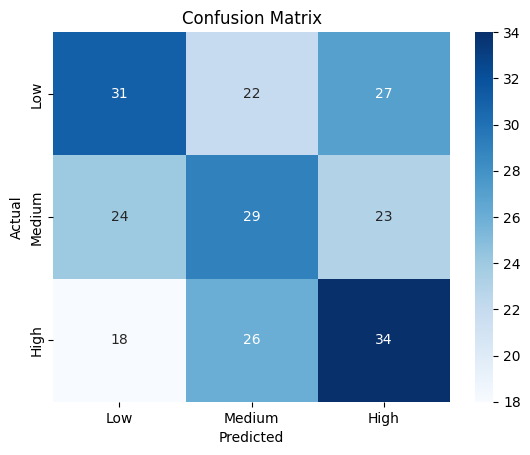

In [24]:
y_ = pd.get_dummies(y).values
X_train, X_test, y_train, y_test = train_test_split(X_scaled[selected_features], y_, test_size=0.3)

# Construção do modelo da rede neural
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Primeira camada oculta com 64 neurônios
model.add(Dense(32, activation='relu'))                              # Segunda camada oculta com 32 neurônios
model.add(Dense(3, activation='softmax'))                            # Camada de saída com 3 neurônios (uma para cada categoria)

# Compilar o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=0.2)

# Avaliar o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Acurácia no conjunto de teste: {accuracy * 100:.2f}%")

# Prever as classes no conjunto de teste
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 4.1 - Nao supervisionado

In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, homogeneity_score, completeness_score

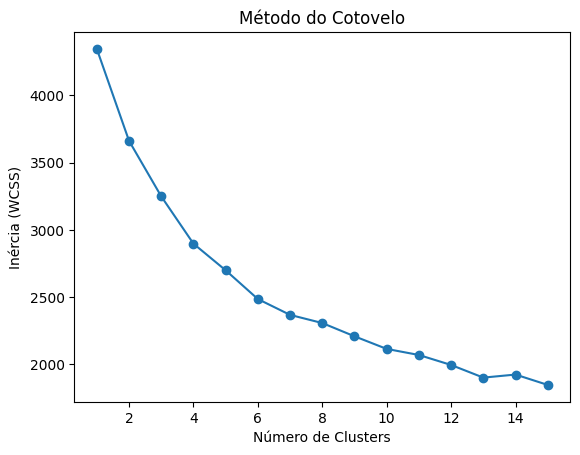

In [35]:
#X_train, X_test = train_test_split(X_scaled[selected_features], test_size=0.3)

# Determinando número ideal de clusters
wcss = []
for i in range(1, 16):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 16), wcss, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia (WCSS)')
plt.show()

In [39]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters)
clusters_train = kmeans.fit_predict(X_train)
clusters_test = kmeans.predict(X_test)

# Métricas de avaliação
inertia = kmeans.inertia_
silhouette_avg = silhouette_score(X_train, clusters_train)
calinski_harabasz = calinski_harabasz_score(X_train, clusters_train)
cluster_distribution = np.unique(clusters_train, return_counts=True)

print("\nK-Means Clustering Metrics")
print("="*60)
print(f"Inércia (WCSS): {inertia}")
print(f"Coeficiente de Silhueta: {silhouette_avg}") # -1 e 1 - Sobreposição de clusters (separacao)
print(f"Índice de Calinski-Harabasz: {calinski_harabasz}")
print(f"Distribuição dos Clusters: {dict(zip(cluster_distribution[0], cluster_distribution[1]))}")
print("\n" + "="*60 + "\n")


K-Means Clustering Metrics
Inércia (WCSS): 2568.9411876260538
Coeficiente de Silhueta: 0.15212705503130375
Índice de Calinski-Harabasz: 74.44636517519459
Distribuição dos Clusters: {np.int32(0): np.int64(33), np.int32(1): np.int64(111), np.int32(2): np.int64(161), np.int32(3): np.int64(92), np.int32(4): np.int64(93), np.int32(5): np.int64(54)}




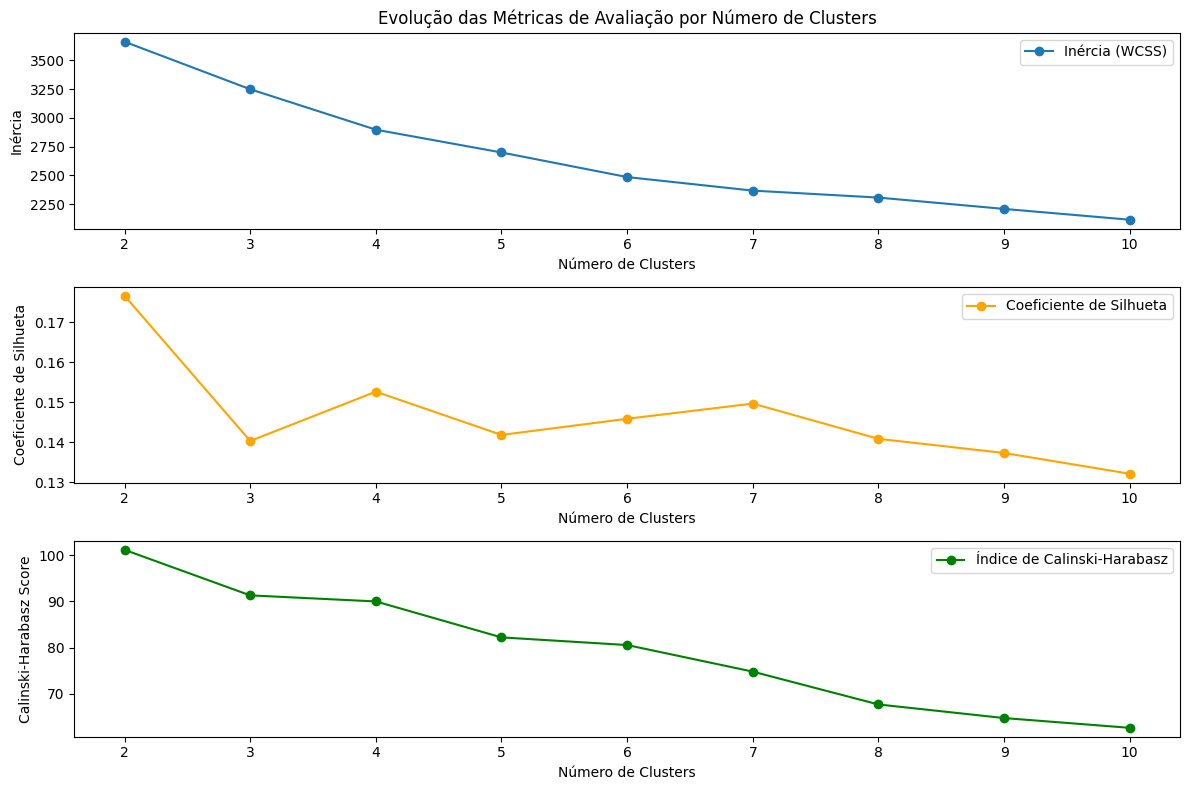

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

cluster_range = range(2, 11)  
inertia_values = []
silhouette_scores = []
calinski_harabasz_scores = []

for n_clusters in cluster_range:
    kmeans2 = KMeans(n_clusters=n_clusters, random_state=42)
    clusters_train2 = kmeans2.fit_predict(X_train)
    
    # Coletar as métricas
    inertia_values.append(kmeans2.inertia_)
    silhouette_scores.append(silhouette_score(X_train, clusters_train2))
    calinski_harabasz_scores.append(calinski_harabasz_score(X_train, clusters_train2))

# Plot das métricas
plt.figure(figsize=(12, 8))

# Inércia
plt.subplot(3, 1, 1)
plt.plot(cluster_range, inertia_values, marker='o', label='Inércia (WCSS)')
plt.title("Evolução das Métricas de Avaliação por Número de Clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Inércia")
plt.legend()

# Coeficiente de Silhueta
plt.subplot(3, 1, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', label='Coeficiente de Silhueta', color='orange')
plt.xlabel("Número de Clusters")
plt.ylabel("Coeficiente de Silhueta")
plt.legend()

# Índice de Calinski-Harabasz
plt.subplot(3, 1, 3)
plt.plot(cluster_range, calinski_harabasz_scores, marker='o', label='Índice de Calinski-Harabasz', color='green')
plt.xlabel("Número de Clusters")
plt.ylabel("Calinski-Harabasz Score")
plt.legend()

# Ajustar layout
plt.tight_layout()
plt.show()


In [42]:
X_train

,artist_count,released_month,danceability_%,valence_%,energy_%,acousticness_%,liveness_%,speechiness_%
662,0.684806,-0.284031,0.234959,-0.618137,-0.800808,1.406925,-0.556673,2.796812
626,0.684806,-0.284031,1.696227,1.112819,-0.482091,0.777513,-0.284117,-0.117800
7,-0.691884,-0.284031,1.209137,-1.251413,-0.163373,-0.559989,0.987811,-0.117800
725,-0.691884,0.274695,-0.878389,-0.238171,-0.035886,-1.032049,-0.011561,-0.009851
283,-0.691884,-0.284031,-0.669636,-1.082539,-1.693216,2.547736,-0.647525,-0.657543
...,...,...,...,...,...,...,...,...
608,-0.691884,-0.842757,0.095790,1.619441,1.685187,-0.796019,1.623775,-0.657543
419,0.684806,-1.401483,0.513295,1.408349,1.238983,-0.638666,1.260367,0.961686
396,-0.691884,1.112784,0.165374,-0.533700,-0.545834,-0.796019,-0.738377,-0.333697
45,-0.691884,-1.122120,-0.252131,1.535004,0.474061,0.974204,-0.011561,-0.549594


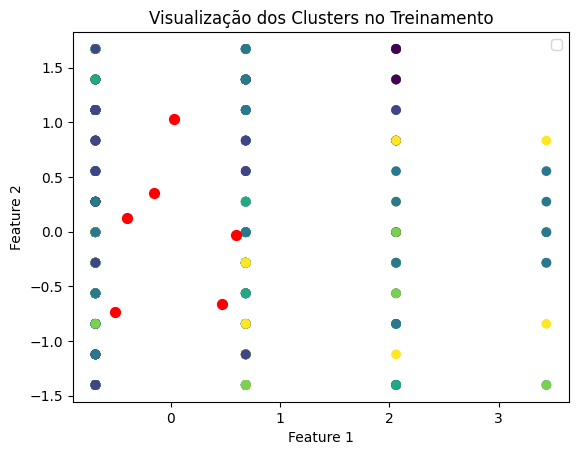

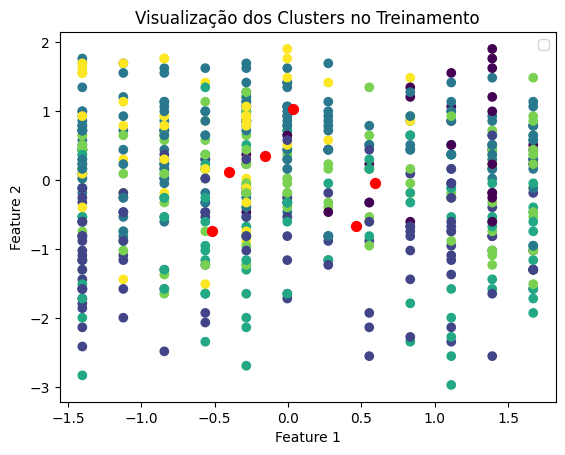

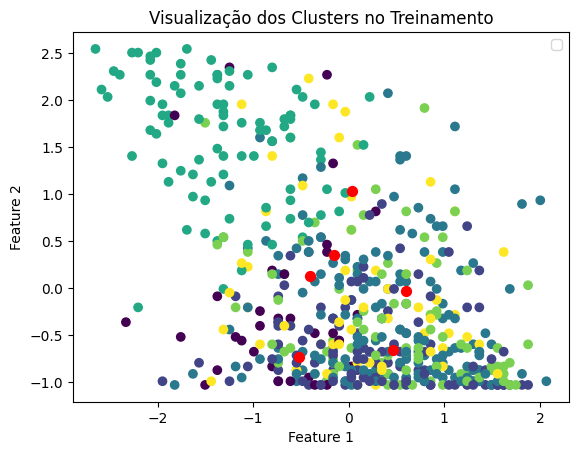

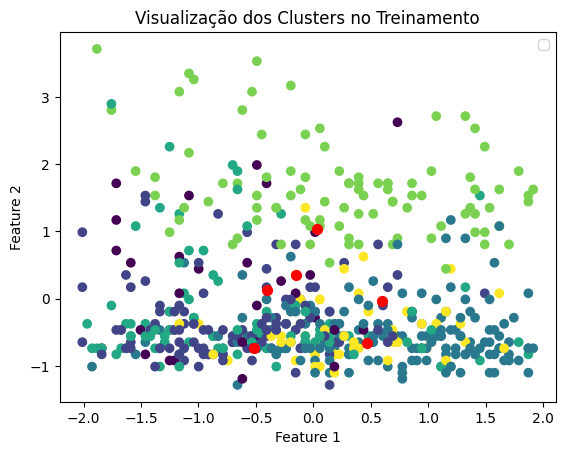

In [43]:
# Visualizando os clusters
for x,y in [(0, 1), (1, 2), (4, 5), (3,6)]:
    plt.scatter(X_train.iloc[:, x], X_train.iloc[:, y], c=clusters_train)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s = 50)
    plt.title('Visualização dos Clusters no Treinamento')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

In [44]:
from sklearn.decomposition import PCA

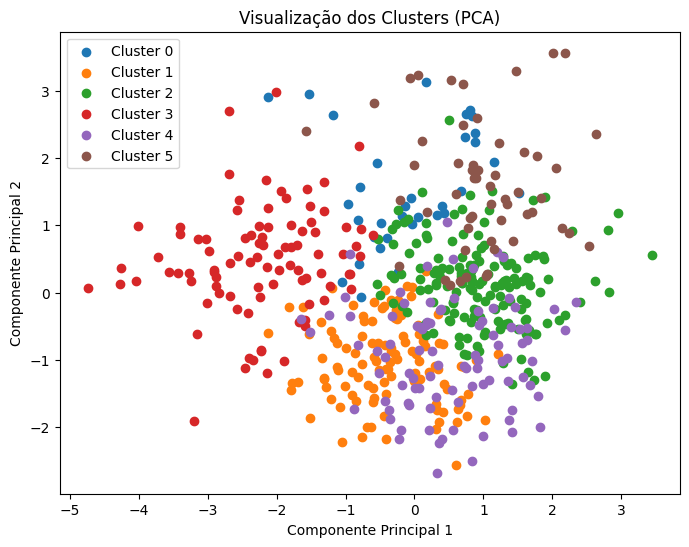

In [47]:
# Reduz os dados para 2 dimensões
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

plt.figure(figsize=(8, 6))
for cluster in np.unique(clusters_train):
    plt.scatter(
        X_train_pca[clusters_train == cluster, 0],
        X_train_pca[clusters_train == cluster, 1],
        label=f'Cluster {cluster}'
    )

plt.title("Visualização dos Clusters (PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.show()


[np.float64(0.00037231527303444674), np.float64(0.0058011087048241115), np.float64(0.002098819409758599), np.float64(0.012026566715684504), np.float64(0.0097304433310085), np.float64(0.013578355348728094), np.float64(0.013086276231323874), np.float64(0.013045794142844774), np.float64(0.01994975956342927)]
[np.float64(0.0004164677089364557), np.float64(0.003492224865827856), np.float64(0.0010020068116425094), np.float64(0.004804784052176038), np.float64(0.003470113819775855), np.float64(0.004592498059905681), np.float64(0.004120740381239943), np.float64(0.0038600253287998047), np.float64(0.005637726443942942)]


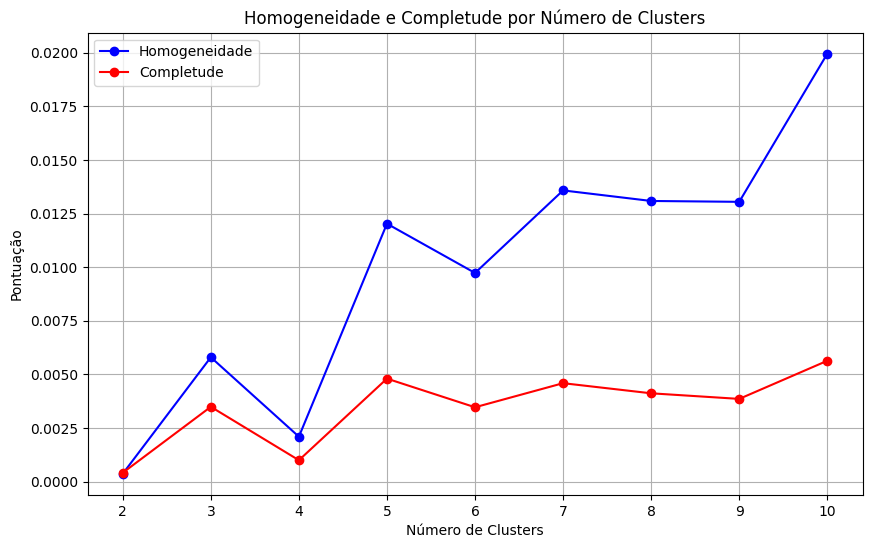

In [53]:
from sklearn.metrics import homogeneity_score, completeness_score

# Garantir que y_train seja unidimensional
y_train = y_train[:, 0] if y_train.ndim > 1 else y_train

homogeneity_scores = []
completeness_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters_train = kmeans.fit_predict(X_train)

    # Cálculo de homogeneidade e completude
    homogeneity_scores.append(homogeneity_score(y_train, clusters_train)) # Cada cluster contém apenas amostra de uma classe
    completeness_scores.append(completeness_score(y_train, clusters_train)) # Cada amostra de uma classe é do mesmo cluster

print(homogeneity_scores)
print(completeness_scores)

# Plot das métricas de homogeneidade e completude
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, homogeneity_scores, marker='o', label='Homogeneidade', color='blue')
plt.plot(cluster_range, completeness_scores, marker='o', label='Completude', color='red')
plt.title("Homogeneidade e Completude por Número de Clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Pontuação")
plt.legend()
plt.grid()
plt.show()
